## Final Project Submission

Please fill out:
* Student name: Julia Müller
* Student pace: FLEX  
* Scheduled project review date/time: 20th December 2022
* Instructor name: Mark Barbour
* Blog post URL: https://hrdatascience1.blogspot.com/2022/12/why-i-chose-data-science.html

### Context and business problem
We have been contracted by Microsoft to give them a recommendation about creating their own movie studio. I will look at what type of movies are doing well, what kind of directors have a great return on investment and how long a potential movie should run.

### Data Loading & Merging
First, I want to load my data and do a quick inspection of the different sources. For this, I need to import the different packages that I foresee to use. I will navigate to the right folder in my repository and then load pandas, numpy, matplotlib, seaborn and sqlite3. For unzipping zipfiles I'll load ZipFile.

In [1]:
#accessing folder
%cd zippedData

C:\Users\mullerju\Documents\Flatiron\Course_Material\Phase_1\Project\dsc-phase-1-project-v2-4\zippedData


In [2]:
#importing the different packages
import pandas as pd #for data manipulation
import numpy as np #for calculations
import matplotlib.pyplot as plt #for visualisation
%matplotlib inline
import seaborn as sns #for visualisation
import sqlite3 #for querying sql data bases
from zipfile import ZipFile #for unzipping zip files

In [3]:
# loading the zip and creating a zip object
with ZipFile(r"C:\Users\mullerju\Documents\Flatiron\Course_Material\Phase_1\Project\dsc-phase-1-project-v2-4\zippedData\im.db.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path=r"C:\Users\mullerju\Documents\Flatiron\Course_Material\Phase_1\Project\dsc-phase-1-project-v2-4\zippedData")

In [4]:
# read in csv from Box Office Mojo (bom), TheMovieDb (tmd) and The Numbers budgets (tnb)
bom = pd.read_csv("bom.movie_gross.csv.gz")
tmd = pd.read_csv("tmdb.movies.csv.gz")
tnb = pd.read_csv("tn.movie_budgets.csv.gz")
# read in tsv from rotten tomatoes one file movies (rtm) and reviews (rtr)
rtm = pd.read_csv("rt.movie_info.tsv.gz", sep="\t")
rtr = pd.read_csv("rt.reviews.tsv.gz", sep="\t", encoding=("latin-1"))

In [5]:
# inspect the 5 csv files.
data = [bom, tmd, tnb, rtm, rtr]
for i in data:
    print(i.info())
    print(i.head())
    print(i.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  

The Box Office Mojo (bom) dataframe contains around 3300 entries with 5 columns (title, studio, domestic_gross, foreign_gross and year. There are some missing values specifically for foreign_gross. Foreign gross is a string and needs to be reformatted. There are many duplicate values for movies with different genres. Therefore, I will not use the genre information from this file.

The The Movie Database (tmd) dataframe contains around 26500 entries with 10 columns ('Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title','popularity', 'release_date', 'title', 'vote_average', 'vote_count'). There are no missing values

The The Numbers (tnb) dataframe contains around 5700 entries with 6 columns ('id', 'release_date', 'movie', 'production_budget', 'domestic_gross','worldwide_gross'). There are no missing values

Rotten Tomatoes Movies(rtm) dataframe has around 1500 entries with 12 columns ('id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime','studio') it has several columns with many missing values, specifically the studio, currency, and box_office columns. 

Rotten Tomatoes Reviews(rtr) dataframe has around 54000 entries with 8 columns ('id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher','date''). For around a fifth of the data set it doesn't have any ratings.

In [6]:
# inspect schema of imdb database
con = sqlite3.connect("im.db")
cur = con.cursor()
schema_df = pd.read_sql(
    """
SELECT *
FROM sqlite_master
""",
    con,
)
schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


From the schema and the columns, I am most interested in the movie_basics, movie_ratings and movie_akas table for my basic info. I will later combine it with the directors table to find out more about which director is successful.

In [7]:
# to get an overview about the number of movies per year in the imdb database
q = pd.read_sql(
    """
SELECT b.start_year, COUNT(*) AS n_movies 
FROM movie_basics as b
JOIN movie_ratings as r
USING (movie_id)
WHERE b.start_year BETWEEN 2015 AND 2020
GROUP BY b.start_year
""",
    con,
)
q.head(10)

,start_year,n_movies
0,2015,8494
1,2016,8721
2,2017,8713
3,2018,7526
4,2019,2180


The latest movie in the database is from 2019. My recommendations will be limited to a point up to this year. There may have been developments since 2019 that would change elements in my recommendation.

In [8]:
# understand how the titles are set up for each movie. I will want to select if something
# is the original title to map it with other tables
q1 = pd.read_sql(
    """
SELECT * 
FROM movie_akas
""",
    con,
)
q1[q1["movie_id"] == "tt0369610"]

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
5,tt0369610,15,Jurassic World,GR,None,imdbDisplay,None,0.0
6,tt0369610,16,Jurassic World,IT,None,imdbDisplay,None,0.0
7,tt0369610,17,Jurski svijet,HR,None,imdbDisplay,None,0.0
8,tt0369610,18,Olam ha'Yura,IL,he,imdbDisplay,None,0.0
9,tt0369610,19,Jurassic World: Mundo Jurásico,MX,None,imdbDisplay,None,0.0


In [9]:
# understand how genres are shown
q4 = pd.read_sql(
    """
SELECT b.genres, SUM(numvotes) AS votes, AVG(r.averagerating) AS avg_rating
FROM movie_ratings as r
LEFT JOIN movie_basics as b
USING (movie_id)
WHERE start_year BETWEEN 2015 AND 2020
GROUP BY b.genres
ORDER BY votes DESC, avg_rating DESC
""",
    con,
)
q4

,genres,votes,avg_rating
0,"Action,Adventure,Sci-Fi",8508126,5.428571
1,"Action,Adventure,Fantasy",5972775,5.790566
2,"Action,Adventure,Comedy",4573290,5.533333
3,"Adventure,Animation,Comedy",3468681,5.939130
4,Drama,2810070,6.597468
...,...,...,...
766,"History,Sport",5,9.200000
767,"Action,Documentary,Horror",5,6.400000
768,"Documentary,Family,Romance",5,6.200000
769,"Family,War",5,5.800000


There are 771 different combinations of genres. Sometimes, there are 3 genres for a movie, so they will have to be split up. I could either go for the different combinations of genres (reordering them would result in a few less combinations) or have a movie appear multiple times depending on how many genres are tagged for that specific movie. I will go for the second option, knowing that this will give movies with more than 1 genre a higher weighting when it comes to calculations like gross or budget.

In [10]:
# Select movies and director info from imdb database
movies2 = pd.read_sql(
    """
SELECT r.movie_id, a.title, r.averagerating AS rating, r.numvotes, b.genres, p.primary_name AS director, b.runtime_minutes
FROM movie_ratings as r
LEFT JOIN movie_basics as b
USING (movie_id)
LEFT JOIN movie_akas as a
USING (movie_id)
LEFT JOIN directors as d
USING (movie_id)
LEFT JOIN persons as p
USING(person_id)
WHERE is_original_title = 1.0
ORDER BY r.averagerating DESC
""",
    con,
)
movies2 = movies2.drop_duplicates(subset=["movie_id"])

In [11]:
# drop null-values and prepare column names to join them.
movies2.dropna()
tnb = tnb.rename(columns={"movie": "title"})
tnb.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [12]:
#Join the Number  data with IMDB data and take only those where both records exist
movies_m = movies2.merge(tnb, how = "inner", on="title")

In [13]:
movies_m.info() #there are only a few missing values, so I decide to drop the whole record.
movies_m.dropna()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2084 entries, 0 to 2083
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2084 non-null   object 
 1   title              2084 non-null   object 
 2   rating             2084 non-null   float64
 3   numvotes           2084 non-null   int64  
 4   genres             2083 non-null   object 
 5   director           2083 non-null   object 
 6   runtime_minutes    2071 non-null   float64
 7   id                 2084 non-null   int64  
 8   release_date       2084 non-null   object 
 9   production_budget  2084 non-null   object 
 10  domestic_gross     2084 non-null   object 
 11  worldwide_gross    2084 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 211.7+ KB


,movie_id,title,rating,numvotes,genres,director,runtime_minutes,id,release_date,production_budget,domestic_gross,worldwide_gross
0,tt1375666,Inception,8.8,1841066,"Action,Adventure,Sci-Fi",Christopher Nolan,148.0,38,"Jul 16, 2010","$160,000,000","$292,576,195","$835,524,642"
1,tt5797286,Yes,8.7,9,"Adventure,Biography,Documentary",Félix Rose,80.0,47,"Jun 24, 2005","$1,700,000","$396,035","$661,221"
2,tt0816692,Interstellar,8.6,1299334,"Adventure,Drama,Sci-Fi",Christopher Nolan,169.0,32,"Nov 5, 2014","$165,000,000","$188,017,894","$666,379,375"
3,tt2421956,Butterfly Girl,8.6,43,Documentary,Cary Bell,78.0,45,"Feb 27, 2015","$180,000","$17,503","$17,503"
4,tt2233624,Kin,8.6,46,"Drama,Music",Rachel Lambert,45.0,88,"Aug 31, 2018","$30,000,000","$5,718,096","$10,096,821"
...,...,...,...,...,...,...,...,...,...,...,...,...
2079,tt2149137,Snow White: A Deadly Summer,2.2,679,Horror,David DeCoteau,83.0,11,"Mar 20, 2012","$1,000,000",$0,$0
2080,tt2909932,Subconscious,2.2,323,"Action,Mystery,Thriller",Georgia Hilton,122.0,78,"Mar 10, 2015","$500,000",$0,$0
2081,tt2814362,United Passions,2.1,3878,"Drama,History,Sport",Frédéric Auburtin,110.0,6,"Jun 5, 2015","$30,000,000",$918,"$168,832"
2082,tt0249516,Foodfight!,1.9,8248,"Action,Animation,Comedy",Lawrence Kasanoff,91.0,26,"Dec 31, 2012","$45,000,000",$0,"$73,706"


### Data Manipulation & Analysis

In [14]:
# the budget data is formatted as string, so I need to change this to integers.
movies_m["production_budget"] = movies_m["production_budget"].apply(
    lambda x: 0 if x == 0 else float(x.split()[0].replace(",", "").replace("$", ""))
)  # reformat as float
movies_m["domestic_gross"] = movies_m["domestic_gross"].apply(
    lambda x: 0 if x == 0 else float(x.split()[0].replace(",", "").replace("$", ""))
)  # reformat as float
movies_m["worldwide_gross"] = movies_m["worldwide_gross"].apply(
    lambda x: 0 if x == 0 else float(x.split()[0].replace(",", "").replace("$", ""))
)  # reformat as float

In [15]:
# create earnings, gross and production budget column in Millions
movies_m["gross-budget"] = movies_m["worldwide_gross"] - movies_m["production_budget"]
movies_m["earning(mio)"] = round(movies_m["gross-budget"] / 1000000)
movies_m["budget(mio)"] = round(movies_m["production_budget"] / 1000000)
movies_m["world_gross(mio)"] = round(movies_m["worldwide_gross"] / 1000000)
movies_m["ROI"] = round(movies_m["budget(mio)"] / movies_m["earning(mio)"] * 100)

In [16]:
# Create a new table that groups the data for each director.
directors = movies_m.groupby(["director"]).agg(
    {
        "world_gross(mio)": ["mean", "count", "sum"],
        "budget(mio)": ["mean"],
        "rating": ["mean"],
        "earning(mio)": ["mean"],
    }
)
directors.columns = [
    "world_gross_avg",
    "movie_count",
    "gross_sum",
    "production_budget_avg",
    "rating_avg",
    "earning_avg",
]  # rename columns
directors = directors.reset_index()  # remove index
directors10 = directors.sort_values(by=["world_gross_avg"], ascending=False).head(
    10
)  # select top 10 directors based on their average earnings.

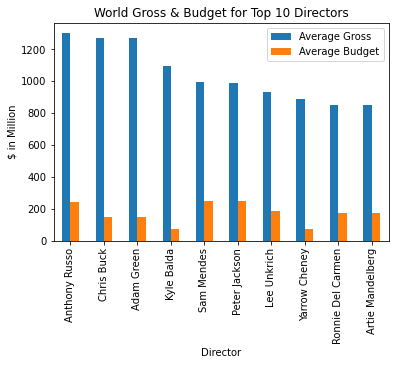

In [17]:
directors10.plot(
    x="director", y=["world_gross_avg", "production_budget_avg"], kind="bar"
)
plt.xlabel("Director")
plt.ylabel("$ in Million")
plt.legend(["Average Gross", "Average Budget"])
plt.title("World Gross & Budget for Top 10 Directors")
plt.show()

In [18]:
directors10["ROI"] = (
    directors10["earning_avg"] / directors10["production_budget_avg"] * 100
)

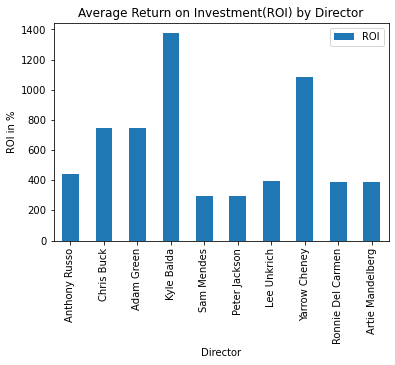

In [19]:
directors10.plot(x="director", y="ROI", kind="bar")
plt.xlabel("Director")
plt.ylabel("ROI in %")
plt.title("Average Return on Investment(ROI) by Director")
plt.show()

The analysis on the top 10 directors shows that they vary depending on their earnings, ROI, gross and production budget. While Anthony Russo clearly has the highest gross, the ROI is comparably low and the production budget is high. Depending on the budget size of  Microsoft's movie studio project, this could be an option. Should an animation movie be an attractive start, a director like Kyle Balda or Yarrow Cheney who both have great ROI would be a viable choice for which the production budget can be smaller.
Next, I will look into the different genres of the past 5 years to understand which genres go well.

In [21]:
# split genres as we sometimes have multiple genres per movie
genres = movies_m.assign(Genre=movies_m["genres"].str.split(",")).explode(
    "genres"
)  # separate multiple genres
genres = genres[["earning(mio)", "rating", "budget(mio)", "Genre"]]  # subset
genres = genres.explode("Genre")
genres1 = (
    genres.groupby(["Genre"])
    .agg(
        {"earning(mio)": ["mean", "count"], "rating": ["mean"], "budget(mio)": ["mean"]}
    )
    .reset_index()
)
genres1.columns = [
    "Genre",
    "avg_earning(mio)",
    "movie_count",
    "rating_avg",
    "budget(mio)_avg",
]
genres1 = genres1.sort_values(by=["avg_earning(mio)"], ascending=False)

genres1["ROI%"] = genres1["avg_earning(mio)"] / genres1["budget(mio)_avg"] * 100

,Genre,avg_earning(mio),movie_count,rating_avg,budget(mio)_avg,ROI%
2,Animation,242.305085,118,6.477966,89.228814,271.554754
1,Adventure,210.921053,418,6.379426,94.088517,224.173002
16,Sci-Fi,186.179191,173,6.229480,74.011561,251.554202
13,Musical,169.416667,12,6.616667,35.500000,477.230047
0,Action,133.667890,545,6.118165,69.917431,191.179635
9,Fantasy,133.151316,152,6.059868,72.493421,183.673655
8,Family,128.706897,116,6.176724,60.198276,213.804955
4,Comedy,81.791733,629,6.214467,35.914149,227.742364
18,Thriller,58.336709,395,5.845063,27.541772,211.811747
14,Mystery,51.853107,177,6.064407,21.158192,245.073431


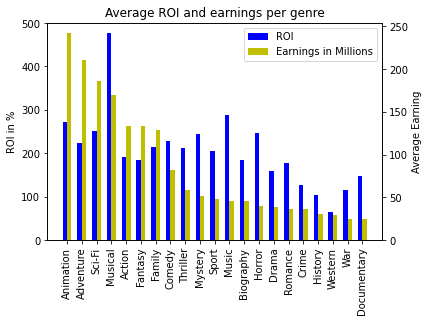

In [22]:
x = np.arange(len(genres1))
ax1 = plt.subplot(1, 1, 1)
w = 0.3
# plt.xticks(), will label the bars on x axis with the respective Genre names.
plt.xticks(x + w / 2, genres1["Genre"], rotation="vertical")
ROI = ax1.bar(x, genres1["ROI%"], width=w, color="b", align="center")
# use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
# gross bars.
earning = ax2.bar(
    x + w, genres1["avg_earning(mio)"], width=w, color="y", align="center"
)
# Set the Y axis label as gross.
ax2.set_ylabel("Average Earning")
ax1.set_ylabel("ROI in %")
plt.title("Average ROI and earnings per genre")
# To set the legend on the plot I have used plt.legend()
plt.legend([ROI, earning], ["ROI", "Earnings in Millions"])
# To show the plot finally I have used plt.show().
plt.show()


Based on the graph, we can see that the Animation & Adventure genre both have an average earning of >200 Million Dollars and an ROI of >200%. The Musical genre seems to be extremely profitable with an ROI of almost 500%. Nevertheless, we should discard this genre because of only 12 data points available which is very likely to be affected by outliers. Our recommendation is to produce an Animation or Adventure movie. We should note that our approach with separating the genres and counting movies twice or thrice, could be impacting the averaged numbers per genre. 

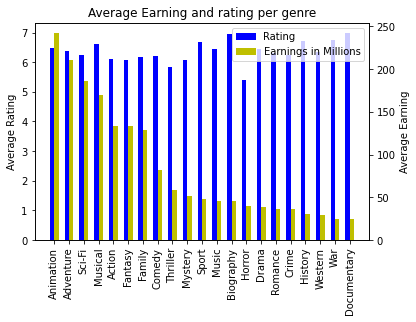

In [23]:
x = np.arange(len(genres1))
ax1 = plt.subplot(1, 1, 1)
w = 0.3
# plt.xticks(), will label the bars on x axis with the respective Genre names.
plt.xticks(x + w / 2, genres1["Genre"], rotation="vertical")
rating = ax1.bar(x, genres1["rating_avg"], width=w, color="b", align="center")
# use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
# gross bars.
earning = ax2.bar(
    x + w, genres1["avg_earning(mio)"], width=w, color="y", align="center"
)
# Set the Y axis label as gross.
ax2.set_ylabel("Average Earning")
ax1.set_ylabel("Average Rating")
plt.title("Average Earning and rating per genre")
# To set the legend on the plot I have used plt.legend()
plt.legend([rating, earning], ["Rating", "Earnings in Millions"])
# To show the plot finally I have used plt.show().
plt.show()

Looking at the average rating of movie genres (even though this was a bit clouded through the multi-genre split), Documentaries have the highest rating but they are the least profitable in terms of average earnings. Thrillers and Horror movies seem to have lower ratings on average. The other genres all seem to be in a similar area of an average rating between 6 and 7. 

In [34]:
genres["rating"].corr(genres["earning(mio)"]) #check correlation of movie ratings and movie earnings.

0.26368580247771833

The rating of a movie only has a weak correlation with the earnings. Other factors seem to be more important for the financial success of a movie.
I will subset the movie with the top 3 Genres (Adventure, Animation and Sci-Fi) to analyse if we should target a different runtime depending on the gender we produce. I will also subset movies that have a rating higher than 6.

In [25]:
# split up the genres
runtime = movies_m.assign(Genre=movies_m["genres"].str.split(",")).explode(
    "genres"
)  # separate multiple genres
runtime = runtime.explode("Genre")
# subset movies from genre
sgenre = ["Adventure", "Animation", "Sci-Fi"]
runtime = runtime[runtime["Genre"].isin(sgenre)]

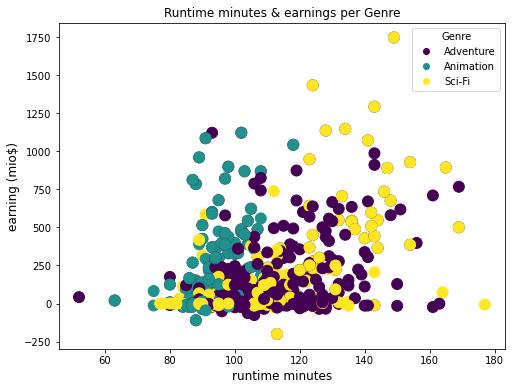

In [78]:
plt.figure(figsize=(8,6))
genres1 = ['Adventure', 'Animation', 'Sci-Fi']
scatter = plt.scatter(runtime["runtime_minutes"],runtime["earning(mio)"],
            s=120,
            c=runtime.Genre.astype('category').cat.codes)
plt.xlabel("runtime minutes", size=12)
plt.ylabel("earning (mio$)", size=12)
plt.title("Runtime minutes & earnings per Genre")
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0], 
           labels=genres1,
           title="Genre");

In [27]:
x.corr(y) #is there a correlation between runtime and earnings?

0.37584613931715993

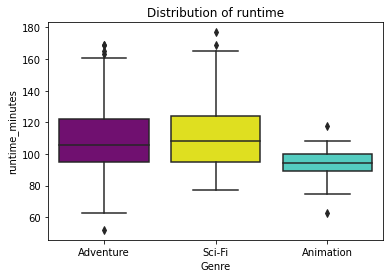

In [83]:
sns.boxplot(
    data=runtime, x="Genre", y="runtime_minutes", palette=["purple", "yellow", "turquoise"]
).set(title="Distribution of runtime");  # create boxplot for different genres

While there is only a weak, positive correlation (.37) between the runtime and earnings of a movie in the genres of Sci-Fi, Animation and Adventure, we can see that the majority of Animation movies are around 100 minutes. The runtime variance of Sci-Fi and Adventure movies is much higher, starting with 80-minutes adventure movies and 180 minutes Sci-Fi movies. Should Microsoft produce an Animation movie, it is recommended to aim for 100 minutes. For a Sci-Fi movie the graph suggests that a length of around 140 minutes could be promising. We can see in the boxplot that the Sci-Fi Genre tends to have fewer short movies than the other genres. For Adventure  movies, there is no clear pattern to see, but a the boxplot suggests that a runtime around 100-120 minutes should work well.

In [29]:
bom.head()  # look at bom database
bom[bom["title"].str.contains("Avengers")]  # look at example
bom["foreign_gross"] = pd.to_numeric(bom["foreign_gross"], errors="coerce")  # reformat
bom["total_gross"] = (
    bom["foreign_gross"] + bom["domestic_gross"]
)  # calculate total gross
top100 = bom.sort_values(by="total_gross", ascending=False)[
    :100
]  # look at top 100 movies by gross

Finally, we will look at the different studios, gross and how many movies they produced in the Box Office Mojo data base

In [30]:
# prepare merging of imdb data with bom data
q6 = pd.read_sql(
    """
SELECT genres, runtime_minutes, primary_title AS title
FROM movie_basics
""",
    con,
)

,genres,runtime_minutes,title
0,"Action,Crime,Drama",175.0,Sunghursh
1,"Biography,Drama",114.0,One Day Before the Rainy Season
2,Drama,122.0,The Other Side of the Wind
3,"Comedy,Drama",NaN,Sabse Bada Sukh
4,"Comedy,Drama,Fantasy",80.0,The Wandering Soap Opera


In [31]:
# Join the Number  data with IMDB data and take only those where both records exist
bom_movies = bom.merge(q6, how="inner", on="title")
bom_movies.sort_values(by=("total_gross"), ascending=False).head(
    10
)  # look at highest grossing movies
bom_movies = bom_movies.drop_duplicates(
    subset="title"
)  # we see several duplicate values so we drop them
bom_movies["total_gross"] = (
    bom_movies["total_gross"] / 1000000
)  # reformat gross in millions
years = (
    bom_movies.groupby(by="year")["title"].count().reset_index().head(10)
)  # look at movies per year
# Sort movies by studio and show number of movies per studio and the sum of total gross.
studios = (
    bom_movies.groupby(["studio"])
    .agg({"title": ["count"], "total_gross": ["sum"]})
    .reset_index()
)
studios.columns = ["Studio", "Movie_Count", "Total_Gross"]
studios = studios.sort_values(by=["Total_Gross"], ascending=False)
studios1 = studios.head(10)  # look at top 10 studios

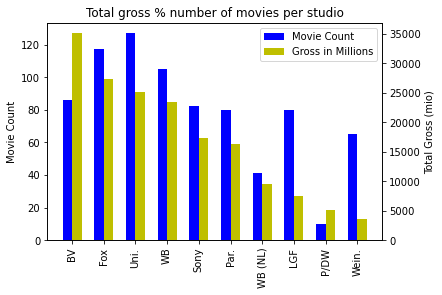

In [32]:
# plot count and gross per studio
x = np.arange(len(studios1))
ax1 = plt.subplot(1, 1, 1)
w = 0.3
# plt.xticks(), will label the bars on x axis with the respective Studio names.
plt.xticks(x + w / 2, studios1["Studio"], rotation="vertical")
Count = ax1.bar(x, studios1["Movie_Count"], width=w, color="b", align="center")
# use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
# gross bars.
gross = ax2.bar(x + w, studios1["Total_Gross"], width=w, color="y", align="center")
# Set the Y axis label as gross.
ax2.set_ylabel("Total Gross (mio)")
ax1.set_ylabel("Movie Count")
plt.title("Total gross % number of movies per studio")
# To set the legend on the plot I have used plt.legend()
plt.legend([rating, earning], ["Movie Count", "Gross in Millions"])
# To show the plot finally I have used plt.show().
plt.show()


Buena Vista is the highest grossing movie studio. We only have data from 2010 til 2018 but it gives us an impression.

# Recommendation
To answer Microsofts question about what to keep in mind for creating an own movie studio, we looked at different factors:
First, the movie studio industry is very lucrative if you look at the gross per studio from 2010 - 2018. Looking at the genres, especially Sci-Fi, Adventures and Animation movies produce high earnings. While documentaries have high ratings, their profitability is not as high. There is only a weak correlation between rating and earnings. It's important to pick the right director for a specific genre. One recommendation is to go with Kyle Balda in the animation genre who has a high ROI and comparably low production budget. 
Finally, the runtime of the movie will depend on the genre you chose to produce. For animation movies, the runtime is much shorter than for Sci-Fi or Adventure movies. 